# Nonlinear Programming Visualization

In [1]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywu/Desktop/hopper_sim


## Visualize the Cost Function

In [3]:
# ============================================================
# Initialize Hopper from YAML Configuration
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import yaml
from models.GRP_hopper import simplified_GRP_hopper
from mpl_toolkits.mplot3d import Axes3D

# Load YAML configuration
with open("./cfg/GRP_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)["simplified_GRP_hopper"]

# Initialize hopper with physical parameters
mb = cfg["mb"]
mf = cfg["mf"]
k = cfg["k"]
c = cfg["c"]
l0 = cfg["l0"]
g = cfg["g"]

hopper = simplified_GRP_hopper(mb, mf, k, c, l0, g)

# Get NLP controller parameters
nlp_cfg = cfg["controller"]["NLP"]
x0 = np.array(cfg["x0"][0])

# Initialize NLP controller with Q_bh = 10 and R_u = 0
mode_seq_init = ["stance"] * nlp_cfg["H"]

controller = simplified_GRP_hopper.NLPController(
    hopper=hopper,
    H=nlp_cfg["H"],
    dt=nlp_cfg["dt_control"],
    x0=x0,
    mode_seq=mode_seq_init,
    Q_l=nlp_cfg["Q_l"],
    R_u=0.0,  # Set run cost coefficient to 0
    u_min=nlp_cfg["u_min"],
    u_max=nlp_cfg["u_max"],
    l_ref=nlp_cfg["l_ref"],
    Q_bh=10.0,  # Set Q_bh to 10
    Q_fh=nlp_cfg["Q_fh"],
    Q_bd=nlp_cfg["Q_bd"],
    body_ref=nlp_cfg["body_ref"],
    foot_ref=nlp_cfg["foot_ref"]
)

print("Hopper initialized with:")
print(f"  Q_bh = {controller.Q_bh}")
print(f"  R_u = {controller.R_u}")
print(f"  Body reference = {controller.body_ref}")
print(f"  Leg length reference = {controller.l_ref}")

Hopper initialized with:
  Q_bh = 10.0
  R_u = 0.0
  Body reference = 0.5
  Leg length reference = 0.3


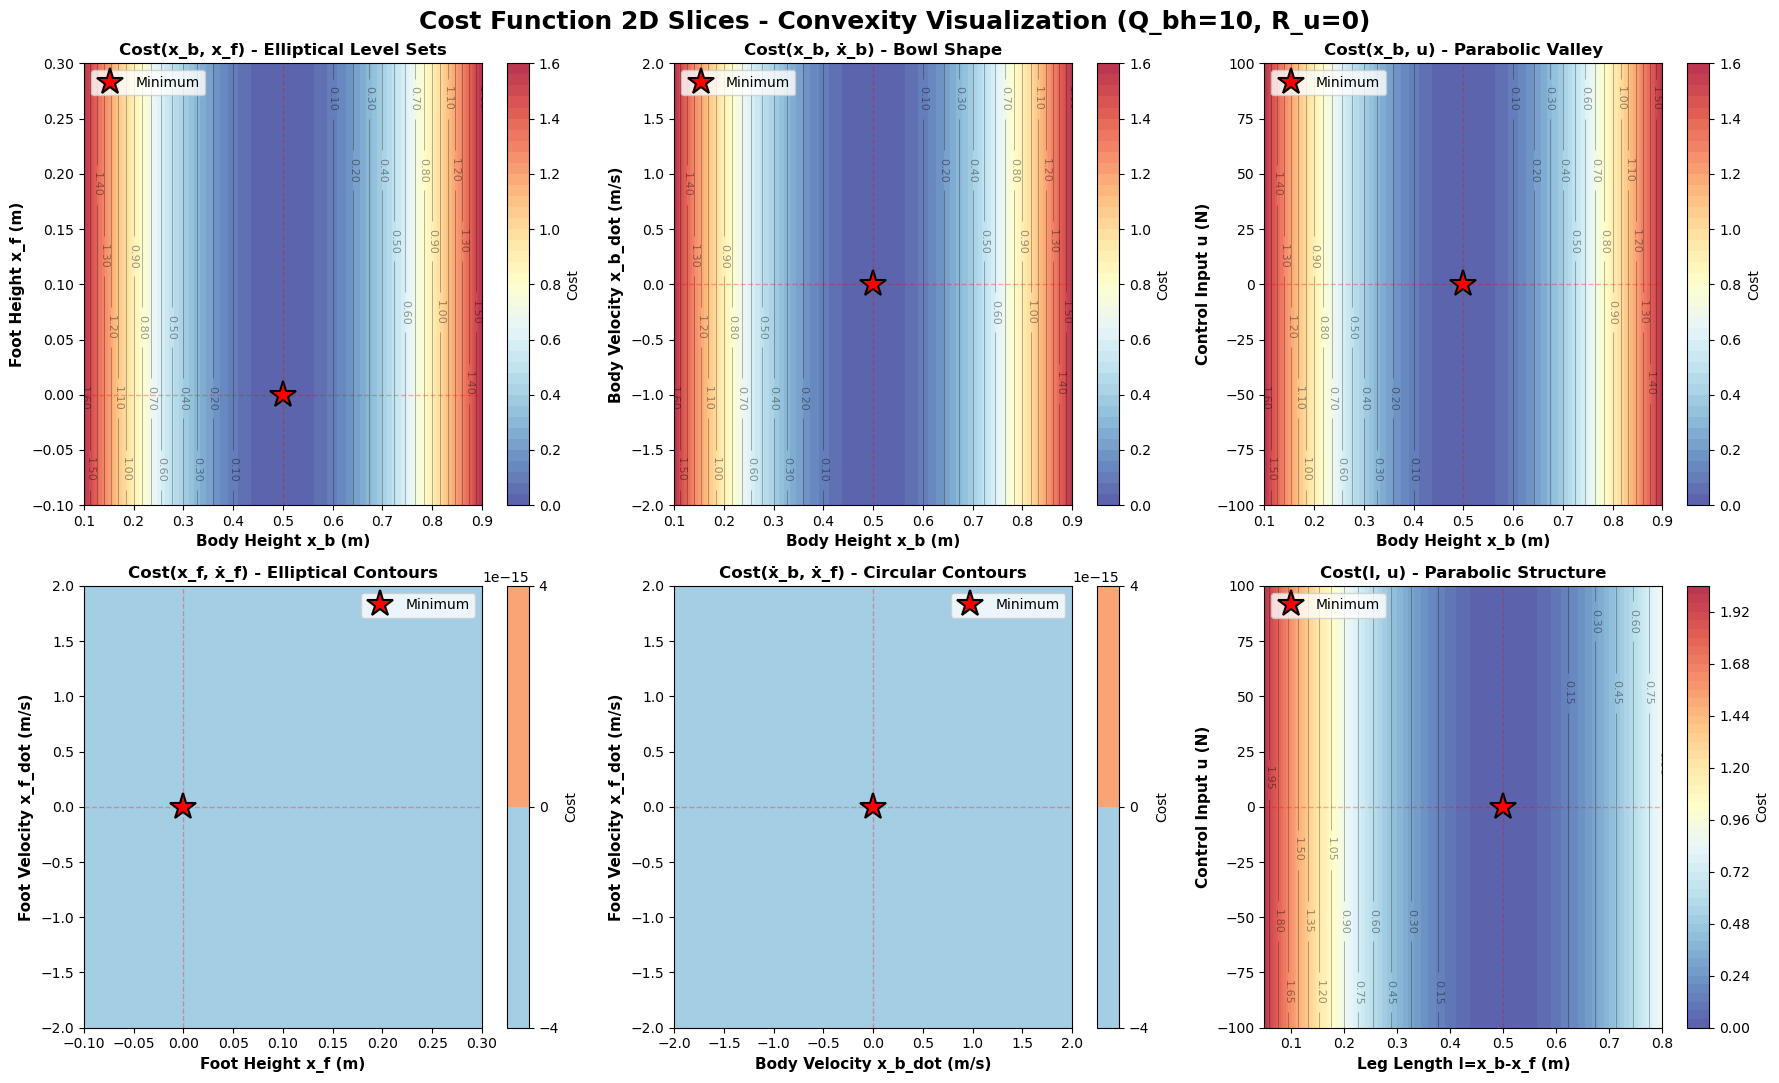

In [4]:
# ============================================================
# Cost Function Visualization - 2D Slices with Enhanced Convexity
# ============================================================
# The cost function has 5 dimensions: x_b, x_b_dot, x_f, x_f_dot, u
# We'll create 2D plots by fixing 3 variables and varying 2

# Define nominal operating point (around equilibrium)
x_b_nom = controller.body_ref  # 0.5 m
x_b_dot_nom = 0.0
x_f_nom = 0.0
x_f_dot_nom = 0.0
u_nom = 0.0

# Define ranges for visualization
x_b_range = np.linspace(0.1, 0.9, 150)
x_b_dot_range = np.linspace(-2.0, 2.0, 150)
x_f_range = np.linspace(-0.1, 0.3, 150)
x_f_dot_range = np.linspace(-2.0, 2.0, 150)
u_range = np.linspace(-100, 100, 150)

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Cost Function 2D Slices - Convexity Visualization (Q_bh=10, R_u=0)', fontsize=18, fontweight='bold')

# ----- Plot 1: x_b vs x_f (body height vs foot height) -----
ax = axes[0, 0]
X_B, X_F = np.meshgrid(x_b_range, x_f_range)
cost_grid = np.zeros_like(X_B)
for i in range(X_B.shape[0]):
    for j in range(X_B.shape[1]):
        x = np.array([X_B[i,j], x_b_dot_nom, X_F[i,j], x_f_dot_nom])
        cost_grid[i,j] = controller._running_cost(x, u_nom)

# Use logarithmic normalization to show curvature better
from matplotlib.colors import LogNorm
vmin, vmax = cost_grid.min(), cost_grid.max()
contourf = ax.contourf(X_B, X_F, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(X_B, X_F, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
ax.plot(x_b_nom, x_f_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(x_b_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(x_f_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Foot Height x_f (m)', fontsize=11, fontweight='bold')
ax.set_title('Cost(x_b, x_f) - Elliptical Level Sets', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

# ----- Plot 2: x_b vs x_b_dot (body height vs body velocity) -----
ax = axes[0, 1]
X_B, X_B_DOT = np.meshgrid(x_b_range, x_b_dot_range)
cost_grid = np.zeros_like(X_B)
for i in range(X_B.shape[0]):
    for j in range(X_B.shape[1]):
        x = np.array([X_B[i,j], X_B_DOT[i,j], x_f_nom, x_f_dot_nom])
        cost_grid[i,j] = controller._running_cost(x, u_nom)

contourf = ax.contourf(X_B, X_B_DOT, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(X_B, X_B_DOT, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
ax.plot(x_b_nom, x_b_dot_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(x_b_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(x_b_dot_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Body Velocity x_b_dot (m/s)', fontsize=11, fontweight='bold')
ax.set_title('Cost(x_b, ẋ_b) - Bowl Shape', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

# ----- Plot 3: x_b vs u (body height vs control) -----
ax = axes[0, 2]
X_B, U = np.meshgrid(x_b_range, u_range)
cost_grid = np.zeros_like(X_B)
for i in range(X_B.shape[0]):
    for j in range(X_B.shape[1]):
        x = np.array([X_B[i,j], x_b_dot_nom, x_f_nom, x_f_dot_nom])
        cost_grid[i,j] = controller._running_cost(x, U[i,j])

contourf = ax.contourf(X_B, U, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(X_B, U, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
ax.plot(x_b_nom, u_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(x_b_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(u_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Control Input u (N)', fontsize=11, fontweight='bold')
ax.set_title('Cost(x_b, u) - Parabolic Valley', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

# ----- Plot 4: x_f vs x_f_dot (foot height vs foot velocity) -----
ax = axes[1, 0]
X_F, X_F_DOT = np.meshgrid(x_f_range, x_f_dot_range)
cost_grid = np.zeros_like(X_F)
for i in range(X_F.shape[0]):
    for j in range(X_F.shape[1]):
        x = np.array([x_b_nom, x_b_dot_nom, X_F[i,j], X_F_DOT[i,j]])
        cost_grid[i,j] = controller._running_cost(x, u_nom)

contourf = ax.contourf(X_F, X_F_DOT, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(X_F, X_F_DOT, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
ax.plot(x_f_nom, x_f_dot_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(x_f_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(x_f_dot_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Foot Height x_f (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Foot Velocity x_f_dot (m/s)', fontsize=11, fontweight='bold')
ax.set_title('Cost(x_f, ẋ_f) - Elliptical Contours', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

# ----- Plot 5: x_b_dot vs x_f_dot (velocities) -----
ax = axes[1, 1]
X_B_DOT, X_F_DOT = np.meshgrid(x_b_dot_range, x_f_dot_range)
cost_grid = np.zeros_like(X_B_DOT)
for i in range(X_B_DOT.shape[0]):
    for j in range(X_B_DOT.shape[1]):
        x = np.array([x_b_nom, X_B_DOT[i,j], x_f_nom, X_F_DOT[i,j]])
        cost_grid[i,j] = controller._running_cost(x, u_nom)

contourf = ax.contourf(X_B_DOT, X_F_DOT, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(X_B_DOT, X_F_DOT, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
ax.plot(x_b_dot_nom, x_f_dot_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(x_b_dot_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(x_f_dot_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Body Velocity x_b_dot (m/s)', fontsize=11, fontweight='bold')
ax.set_ylabel('Foot Velocity x_f_dot (m/s)', fontsize=11, fontweight='bold')
ax.set_title('Cost(ẋ_b, ẋ_f) - Circular Contours', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

# ----- Plot 6: Leg length l vs u (derived quantity) -----
ax = axes[1, 2]
l_range = np.linspace(0.05, 0.8, 150)
L, U = np.meshgrid(l_range, u_range)
cost_grid = np.zeros_like(L)
for i in range(L.shape[0]):
    for j in range(L.shape[1]):
        # l = x_b - x_f, so x_b = l + x_f
        x_b_temp = L[i,j] + x_f_nom
        x = np.array([x_b_temp, x_b_dot_nom, x_f_nom, x_f_dot_nom])
        cost_grid[i,j] = controller._running_cost(x, U[i,j])

contourf = ax.contourf(L, U, cost_grid, levels=50, cmap='RdYlBu_r', alpha=0.8)
contour_lines = ax.contour(L, U, cost_grid, levels=15, colors='black', linewidths=0.5, alpha=0.4)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
l_nom = x_b_nom - x_f_nom
ax.plot(l_nom, u_nom, 'r*', markersize=20, label='Minimum', markeredgecolor='black', markeredgewidth=1.5)
ax.axvline(l_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(u_nom, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xlabel('Leg Length l=x_b-x_f (m)', fontsize=11, fontweight='bold')
ax.set_ylabel('Control Input u (N)', fontsize=11, fontweight='bold')
ax.set_title('Cost(l, u) - Parabolic Structure', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('Cost', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# Cost Function Visualization - 3D Surfaces (Enhanced Convexity)
# ============================================================
# Create 3D visualizations with better viewing angles and visual cues

fig = plt.figure(figsize=(20, 14))
fig.suptitle('3D Cost Function Surfaces - Convex Bowl Shapes (Q_bh=10, R_u=0)', 
             fontsize=18, fontweight='bold', y=0.98)

# ----- 3D Plot 1: x_b, x_f, and cost in z-axis -----
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

# Sample points for 3D visualization
x_b_3d = np.linspace(0.1, 0.9, 60)
x_f_3d = np.linspace(-0.1, 0.3, 60)
X_B_3d, X_F_3d = np.meshgrid(x_b_3d, x_f_3d)
cost_3d = np.zeros_like(X_B_3d)

for i in range(X_B_3d.shape[0]):
    for j in range(X_B_3d.shape[1]):
        x = np.array([X_B_3d[i,j], x_b_dot_nom, X_F_3d[i,j], x_f_dot_nom])
        cost_3d[i,j] = controller._running_cost(x, u_nom)

# Plot surface with better shading
surf1 = ax1.plot_surface(X_B_3d, X_F_3d, cost_3d, cmap='coolwarm', 
                         alpha=0.9, edgecolor='none', antialiased=True,
                         vmin=cost_3d.min(), vmax=np.percentile(cost_3d, 95))
# Add contour lines at the bottom
min_cost = cost_3d.min()
ax1.contour(X_B_3d, X_F_3d, cost_3d, levels=20, zdir='z', 
            offset=min_cost-0.5, cmap='coolwarm', alpha=0.6, linewidths=1.5)
# Mark the minimum
ax1.scatter([x_b_nom], [x_f_nom], [cost_3d.min()], color='red', s=150, 
            marker='*', edgecolors='black', linewidths=2, label='Global Minimum', zorder=10)
ax1.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_ylabel('Foot Height x_f (m)', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_zlabel('Cost', fontsize=11, fontweight='bold', labelpad=10)
ax1.set_title('Cost(x_b, x_f) - Parabolic Bowl', fontsize=12, fontweight='bold', pad=15)
ax1.view_init(elev=25, azim=45)
ax1.legend(loc='upper left')
fig.colorbar(surf1, ax=ax1, shrink=0.5, pad=0.1)

# ----- 3D Plot 2: x_b, x_b_dot, and cost -----
ax2 = fig.add_subplot(2, 2, 2, projection='3d')

x_b_dot_3d = np.linspace(-2.0, 2.0, 60)
X_B_3d, X_B_DOT_3d = np.meshgrid(x_b_3d, x_b_dot_3d)
cost_3d = np.zeros_like(X_B_3d)

for i in range(X_B_3d.shape[0]):
    for j in range(X_B_3d.shape[1]):
        x = np.array([X_B_3d[i,j], X_B_DOT_3d[i,j], x_f_nom, x_f_dot_nom])
        cost_3d[i,j] = controller._running_cost(x, u_nom)

surf2 = ax2.plot_surface(X_B_3d, X_B_DOT_3d, cost_3d, cmap='plasma', 
                         alpha=0.9, edgecolor='none', antialiased=True,
                         vmin=cost_3d.min(), vmax=np.percentile(cost_3d, 95))
min_cost = cost_3d.min()
ax2.contour(X_B_3d, X_B_DOT_3d, cost_3d, levels=20, zdir='z',
            offset=min_cost-0.5, cmap='plasma', alpha=0.6, linewidths=1.5)
ax2.scatter([x_b_nom], [x_b_dot_nom], [cost_3d.min()], color='red', s=150,
            marker='*', edgecolors='black', linewidths=2, label='Global Minimum', zorder=10)
ax2.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold', labelpad=10)
ax2.set_ylabel('Body Velocity ẋ_b (m/s)', fontsize=11, fontweight='bold', labelpad=10)
ax2.set_zlabel('Cost', fontsize=11, fontweight='bold', labelpad=10)
ax2.set_title('Cost(x_b, ẋ_b) - Quadratic Surface', fontsize=12, fontweight='bold', pad=15)
ax2.view_init(elev=25, azim=45)
ax2.legend(loc='upper left')
fig.colorbar(surf2, ax=ax2, shrink=0.5, pad=0.1)

# ----- 3D Plot 3: x_b, u, and cost -----
ax3 = fig.add_subplot(2, 2, 3, projection='3d')

u_3d = np.linspace(-100, 100, 60)
X_B_3d, U_3d = np.meshgrid(x_b_3d, u_3d)
cost_3d = np.zeros_like(X_B_3d)

for i in range(X_B_3d.shape[0]):
    for j in range(X_B_3d.shape[1]):
        x = np.array([X_B_3d[i,j], x_b_dot_nom, x_f_nom, x_f_dot_nom])
        cost_3d[i,j] = controller._running_cost(x, U_3d[i,j])

surf3 = ax3.plot_surface(X_B_3d, U_3d, cost_3d, cmap='viridis', 
                         alpha=0.9, edgecolor='none', antialiased=True,
                         vmin=cost_3d.min(), vmax=np.percentile(cost_3d, 95))
min_cost = cost_3d.min()
ax3.contour(X_B_3d, U_3d, cost_3d, levels=20, zdir='z',
            offset=min_cost-0.5, cmap='viridis', alpha=0.6, linewidths=1.5)
ax3.scatter([x_b_nom], [u_nom], [cost_3d.min()], color='red', s=150,
            marker='*', edgecolors='black', linewidths=2, label='Global Minimum', zorder=10)
ax3.set_xlabel('Body Height x_b (m)', fontsize=11, fontweight='bold', labelpad=10)
ax3.set_ylabel('Control u (N)', fontsize=11, fontweight='bold', labelpad=10)
ax3.set_zlabel('Cost', fontsize=11, fontweight='bold', labelpad=10)
ax3.set_title('Cost(x_b, u) - Parabolic Valley', fontsize=12, fontweight='bold', pad=15)
ax3.view_init(elev=25, azim=45)
ax3.legend(loc='upper left')
fig.colorbar(surf3, ax=ax3, shrink=0.5, pad=0.1)

# ----- 3D Plot 4: Leg length l, u, and cost -----
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

l_3d = np.linspace(0.05, 0.8, 60)
L_3d, U_3d = np.meshgrid(l_3d, u_3d)
cost_3d = np.zeros_like(L_3d)

for i in range(L_3d.shape[0]):
    for j in range(L_3d.shape[1]):
        x_b_temp = L_3d[i,j] + x_f_nom
        x = np.array([x_b_temp, x_b_dot_nom, x_f_nom, x_f_dot_nom])
        cost_3d[i,j] = controller._running_cost(x, U_3d[i,j])

surf4 = ax4.plot_surface(L_3d, U_3d, cost_3d, cmap='inferno', 
                         alpha=0.9, edgecolor='none', antialiased=True,
                         vmin=cost_3d.min(), vmax=np.percentile(cost_3d, 95))
min_cost = cost_3d.min()
ax4.contour(L_3d, U_3d, cost_3d, levels=20, zdir='z',
            offset=min_cost-0.5, cmap='inferno', alpha=0.6, linewidths=1.5)
l_nom = x_b_nom - x_f_nom
ax4.scatter([l_nom], [u_nom], [cost_3d.min()], color='red', s=150,
            marker='*', edgecolors='black', linewidths=2, label='Global Minimum', zorder=10)
ax4.set_xlabel('Leg Length l (m)', fontsize=11, fontweight='bold', labelpad=10)
ax4.set_ylabel('Control u (N)', fontsize=11, fontweight='bold', labelpad=10)
ax4.set_zlabel('Cost', fontsize=11, fontweight='bold', labelpad=10)
ax4.set_title('Cost(l, u) - Convex Surface', fontsize=12, fontweight='bold', pad=15)
ax4.view_init(elev=25, azim=45)
ax4.legend(loc='upper left')
fig.colorbar(surf4, ax=ax4, shrink=0.5, pad=0.1)

plt.tight_layout()
plt.show()
